In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm

import math

from pandas.core.dtypes.cast import validate_numeric_casting
import torch.optim as optim
import pathlib

import pickle

!pip install colorama
import colorama
from colorama import Fore, Style

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Utility functions

In [3]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

def df_to_tensor(df):
    device = get_device()
    return torch.tensor(df.values).float().to(device)

def get_data(file_name, seq_len, input_fields, output_fields, val_ratio=0.01, transpose_data=False):
    # Get data from csv
    df = pd.read_csv(file_name, names=['datetime','PRICE','SIZE','vol','vol_horizon','PRICE_horizon','PRICE_slope_horizon','vol_slope_horizon'])
    inputs = df_to_tensor(df[input_fields])
    outputs = df_to_tensor(df[output_fields])
    
    # Group seq_len concecutive input points together, and horizon concecutive output vectors together
    inputs = torch.stack([inputs[i:i - seq_len] for i in range(seq_len)], dim = 1)
    outputs = outputs[seq_len:]

    assert len(inputs) == len(outputs), f"Input and output arrays have different lengths: {len(inputs)} \= {len(outputs)}"
    
    # Do train/validation split
    val_len = math.ceil(val_ratio * len(inputs))

    if transpose_data:
      train_x = inputs[:-val_len].transpose(1,2)
      train_y = outputs[:-val_len]
      val_x = inputs[-val_len:].transpose(1,2)
      val_y = outputs[-val_len:]
    else:
      train_x = inputs[:-val_len]
      train_y = outputs[:-val_len]
      val_x = inputs[-val_len:]
      val_y = outputs[-val_len:]

    print("Train input dimension:", train_x.shape)
    print("Train output dimension:", train_y.shape)
    print("Validation input dimension:", val_x.shape)
    print("Validation output dimension:", val_y.shape)

    return train_x, train_y, val_x, val_y

# def get_data_multiple_horizons(file_name, input_dim, horizon, val_ratio=0.01):
#     # Get data from csv
#     df = pd.read_csv(file_name)
#     inputs = df_to_tensor(df[['vol']])
#     outputs = df_to_tensor(df[['vol']])
    
#     # Group input_dim concecutive input points together, and horizon concecutive output vectors together
#     inputs = torch.stack([inputs[i:i - input_dim - horizon] for i in range(input_dim)], dim = 1)
#     outputs = torch.stack([outputs[input_dim + i:i - horizon] for i in range(horizon)], dim = 1).squeeze()

#     assert len(inputs) == len(outputs), f"Input and output arrays have different lengths: {len(inputs)} \= {len(outputs)}"
    
#     # Do train/validation split
#     val_len = math.ceil(val_ratio * len(inputs))
#     train_x = inputs[:-val_len]
#     train_y = outputs[:-val_len]
#     val_x = inputs[-val_len:]
#     val_y = outputs[-val_len:]

#     print("Train input dimension:", train_x.shape)
#     print("Train output dimension:", train_y.shape)
#     print("Validation input dimension:", val_x.shape)
#     print("Validation output dimension:", val_y.shape)

#     return train_x, train_y, val_x, val_y

In [4]:
def classifier_accuracy(model, x, y, num_samples):
  assert num_samples <= len(x), f"Too many samples: {num_samples}. Input size is only {len(x)}"
  out = model(x[:num_samples]).squeeze()
  pred = out >= 0
  reality = y[:num_samples].squeeze()

  correct = (pred == reality).sum().item()
  return correct/num_samples

In [5]:
def plot_model_performance_single_horizon(model, x, y, num_samples):
  assert num_samples <= len(x), f"Too many samples: {num_samples}. Input size is only {len(x)}"
  pred = model(x[:num_samples])
  reality = y[:num_samples]

  plt.plot(pred.cpu().detach().numpy(), 'r')
  plt.plot(reality.cpu().detach().numpy(), 'b')

# def plot_model_performance_multiple_horizons(model, x, y, num_samples, horizon):
#   assert num_samples < len(x), f"Too many samples: {num_samples}. Input size is only {len(x)}"
#   pred = model(x[:num_samples])[:, horizon-1]
#   reality = y[:num_samples][:, horizon-1]

#   plt.plot(pred.detach().numpy(), 'r')
#   plt.plot(reality.detach().numpy(), 'b')

### Adapted TCN Implementation

Bai, S., Kolter, J. Z., & Koltun, V. (2018). An empirical evaluation of generic convolutional and recurrent networks for sequence modeling. arXiv preprint arXiv:1803.01271.

Official TCN PyTorch implementation: https://github.com/locuslab/TCN


In [6]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2,device=None):
        super(TemporalBlock, self).__init__()

        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation, device=device))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation, device=device))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1, device=device) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2, device=None):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout, device=device)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

### Custom model definitions 

In [7]:
# Generic TCN class
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout, device=None):
        super(TCN, self).__init__()

        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout, device=device)
        self.linear = nn.Linear(num_channels[-1], output_size, device=device)

    def forward(self, inputs):
        """Inputs have to have dimension (N, C_in, L_in)"""
        y1 = self.tcn(inputs)  # input should have dimension (N, C, L)
        o = self.linear(y1[:, :, -1])
        return o

# Generic MLP class
class MLP(nn.Module):
    def __init__(self, input_size, num_channels, output_size, dropout, device=None):
        super(MLP, self).__init__()

        dims = [input_size] + num_channels + [output_size]
        mlp_layers = []
        for i in range(len(dims) - 1):
            if i == len(dims) - 2:
              linear = nn.Linear(dims[i], dims[i+1], device=device)
              mlp_layers += [linear]
            else:
              linear = nn.Linear(dims[i], dims[i+1], device=device)
              drop = nn.Dropout(dropout)
              relu = nn.ReLU()
              mlp_layers += [linear, drop, relu]
        
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, inputs):
        return self.mlp(inputs)


In [8]:
# Model that uses LSTM
class ForecastLSTM(nn.Module):
    def __init__(self, args):
        super(ForecastLSTM, self).__init__()
        self.sequence_len = args.sequence_len
        self.input_size = args.input_size

        device = get_device()

        self.lstm = nn.LSTM(input_size=args.input_size, hidden_size=args.hidden_size, num_layers=args.num_layers_lstm, bias=False, 
                            batch_first=True, dropout=args.dropout_lstm, device=device)
        
        self.mlp = MLP(input_size=args.sequence_len * args.hidden_size, num_channels=args.num_channels_mlp, 
                       output_size=1, dropout=args.dropout_mlp,device=device)

    
    def forward(self, x):
        o, _ = self.lstm(x)
        return self.mlp(o.reshape((o.shape[0], o.shape[1]*o.shape[2])))


# Model that uses TCN
class ForecastTCN(nn.Module):
    def __init__(self, args):
        super(ForecastTCN, self).__init__()
        self.sequence_len = args.sequence_len
        self.input_size = args.input_size
        device=get_device()

        self.tcn = TCN(input_size=args.input_size, output_size=args.num_channels_mlp[0], 
                       num_channels=args.num_channels_tcn, kernel_size=args.kernel_size, 
                       dropout=args.dropout_tcn, device=device)

        self.mlp = MLP(input_size=args.num_channels_mlp[0], num_channels=args.num_channels_mlp[1:], 
                       output_size=1, dropout=args.dropout_mlp,device=device)
  
    def forward(self, x):
        tcn_o = F.relu(self.tcn(x))
        mlp_o = self.mlp(tcn_o)
        return mlp_o


# Model that predicts output accross multiple horizons simultaneously
# 
# class VolForecast(nn.Module):
#     def __init__(self, input_dim, horizon):
#         super(VolForecast, self).__init__()
#         self.input_dim = input_dim
#         self.horizon = horizon

#         self.tcn = TCN(input_size=input_dim, output_size=horizon, num_channels=[300, 250, 200, 200, 150, 100], kernel_size=7, dropout=0.1)
    
#     def forward(self, x):
#         return self.tcn(x)

### Model evaluation

In [9]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [10]:
def train(args, train_x, train_y, val_x, val_y):
    
    print(args)
    
    # Save directory
    save_dir = "outputs/" + args.experiment_name
    pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Save params for cross-reference
    ags_file = open(f"{save_dir}/args", "wb")
    pickle.dump(args, ags_file)
    ags_file.close()

    # Loss function
    loss_fn = args.loss_fn

    # Model and optimizer
    model = args.model(args)
    optimizer = optim.Adam(model.parameters(), lr=args.learn_rate)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(args.nepochs):
        # Sample batch input randomly
        random_ids = np.random.randint(len(train_x), size=args.batch_size)
        train_input = train_x[random_ids]
        train_output = train_y[random_ids]        

        optimizer.zero_grad()
        loss = loss_fn(model(train_input), train_output)
        accuracy = classifier_accuracy(model, train_input, train_output, args.batch_size)
        loss.backward()
        optimizer.step()

        train_losses += [loss]
        train_accuracies += [accuracy]

        print(f"Epoch: {epoch + 1}, training loss: {loss}, training accuracy: {accuracy}")

        if args.validate and (epoch+1) % args.validation_frequency == 0:

            val_loss = loss_fn(model(val_x), val_y)
            val_losses += [val_loss]

            val_accuracy = classifier_accuracy(model, val_x, val_y, len(val_x))
            val_accuracies += [val_accuracy]

            print(f"{Fore.RED} Validation loss: {val_loss}, validation accuracy: {val_accuracy} {Style.RESET_ALL}")
    
    torch.save(model.state_dict(), f"{save_dir}/model_params")


    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [11]:
args = AttrDict()

### Arguments for data split, training hyperparameters, etc.
args_generic = {
    # Generic
    "data_path": '/content/drive/MyDrive/sasha/csc413/2sec.csv',
    "seed": 0,
    "experiment_name": "simple_TCN_volatility",

    # Validation
    "validate": True,
    "validation_frequency": 500,
    "val_ratio": 0.002,

    # Input/output params
    "sequence_len": 300,
    "input_fields": ['PRICE', 'SIZE', 'vol'],
    "output_fields": ['vol_slope_horizon'],

    # Model 
    "model": ForecastTCN,
    "loss_fn": nn.BCEWithLogitsLoss(),

    # Learning
    "learn_rate": 0.001,
    "batch_size": 64,
    "nepochs": 2000,
}
args.update(args_generic)


### Architecture params, given per model
if args_generic['model'] == ForecastTCN:
  args_tcn = {
      "transpose_data": True, # don't change
      "input_size": len(args_generic['input_fields']), # don't change

      # Parameters for TCN part
      "num_channels_tcn": 6*[25],
      "kernel_size": 7,
      "dropout_tcn": 0.1,

      # Params for MLP part
      "num_channels_mlp": 2*[25],
      "dropout_mlp": 0.1,
  }

  args.update(args_tcn)
elif args_generic['model'] == ForecastLSTM:
  args_lstm = {
      "transpose_data": False, # don't change
      "input_size": len(args_generic['input_fields']), # don't change

      # Parameters for LSTM part
      "hidden_size": 64,
      "num_layers_lstm": 2,
      "dropout_lstm": 0.1,

      # Parameters for MLP part
      "num_channels_mlp": 2*[25],
      "dropout_mlp": 0.1,
  }
  args.update(args_lstm)


In [12]:
# Loading the data
train_x, train_y, val_x, val_y = get_data(args.data_path, seq_len=args.sequence_len, input_fields=args.input_fields, 
                                          output_fields=args.output_fields, val_ratio=args.val_ratio, transpose_data=args.transpose_data)

Train input dimension: torch.Size([1043582, 3, 300])
Train output dimension: torch.Size([1043582, 1])
Validation input dimension: torch.Size([2092, 3, 300])
Validation output dimension: torch.Size([2092, 1])


In [13]:
# Training
model, train_losses, val_losses, train_accuracies, val_accuracies = train(args, train_x, train_y, val_x, val_y)

{'data_path': '/content/drive/MyDrive/sasha/csc413/2sec.csv', 'seed': 0, 'experiment_name': 'simple_TCN_volatility', 'validate': True, 'validation_frequency': 500, 'val_ratio': 0.002, 'sequence_len': 300, 'input_fields': ['PRICE', 'SIZE', 'vol'], 'output_fields': ['vol_slope_horizon'], 'model': <class '__main__.ForecastTCN'>, 'loss_fn': BCEWithLogitsLoss(), 'learn_rate': 0.001, 'batch_size': 64, 'nepochs': 2000, 'transpose_data': True, 'input_size': 3, 'num_channels_tcn': [25, 25, 25, 25, 25, 25], 'kernel_size': 7, 'dropout_tcn': 0.1, 'num_channels_mlp': [25, 25], 'dropout_mlp': 0.1}
Epoch: 1, training loss: 0.6956802010536194, training accuracy: 0.515625
Epoch: 2, training loss: 0.7061737775802612, training accuracy: 0.46875
Epoch: 3, training loss: 0.6881448030471802, training accuracy: 0.578125
Epoch: 4, training loss: 0.676539421081543, training accuracy: 0.609375
Epoch: 5, training loss: 0.6780059337615967, training accuracy: 0.59375
Epoch: 6, training loss: 0.715370774269104, tra

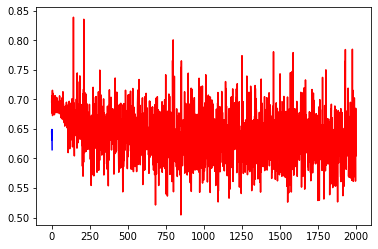

In [14]:
# Graphing losses
plt.plot(np.array([x.cpu().detach().numpy() for x in train_losses]), 'r')
plt.plot(np.array([x.cpu().detach().numpy() for x in val_losses]), 'b')

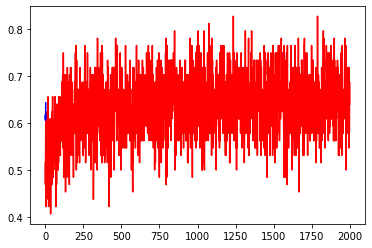

In [15]:
# Graphing accuracies
plt.plot(np.array([x for x in train_accuracies]), 'r')
plt.plot(np.array([x for x in val_accuracies]), 'b')

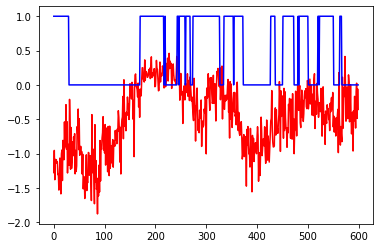

In [16]:
# MODEL PERFORMANCE - TRAINING PART
plot_model_performance_single_horizon(model, train_x, train_y, num_samples=600)

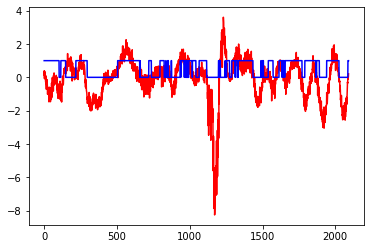

In [17]:
# MODEL'S PERFORMANCE - VALIDATION PART
plot_model_performance_single_horizon(model, val_x, val_y, num_samples=len(val_x))

In [18]:
print("accuracy:", classifier_accuracy(model, val_x, val_y, num_samples=len(val_x)))

accuracy: 0.6496175908221797
